In [1]:
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline
import matplotlib.pylab as plt

In [3]:
import seaborn as sns
sns.set(rc={'figure.figsize':(20.7,8.27)})

In [15]:
from pdkit.gait_time_series import GaitTimeSeries
from pdkit.gait_processor import GaitProcessor
from pdkit.utils import butter_lowpass_filter

In [16]:
import scipy.signal as sig

In [5]:
clean_data = '/home/c/data/pdkit/GAIT_-_2018-06-14_13-50-58_-_d90b653403_-_13311.csv'

In [6]:
gd = GaitTimeSeries.load_data(clean_data, format_file='gait_gyro')

Sampling rate is 499.6666666666667 samples / second


In [7]:
gp = GaitProcessor(sampling_frequency=100.0, filter_order=4, cutoff_frequency=2.0)

In [8]:
d = gp.resample_signal(gd)

Sampling rate is 100.0 samples / second


In [9]:
df = gp.filter_data_frame(d)

In [10]:
start, stop = 20, 3800

In [11]:
df = gp.cut_data_frame(df, start, stop)

/home/c/lab/envs/pdkit/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


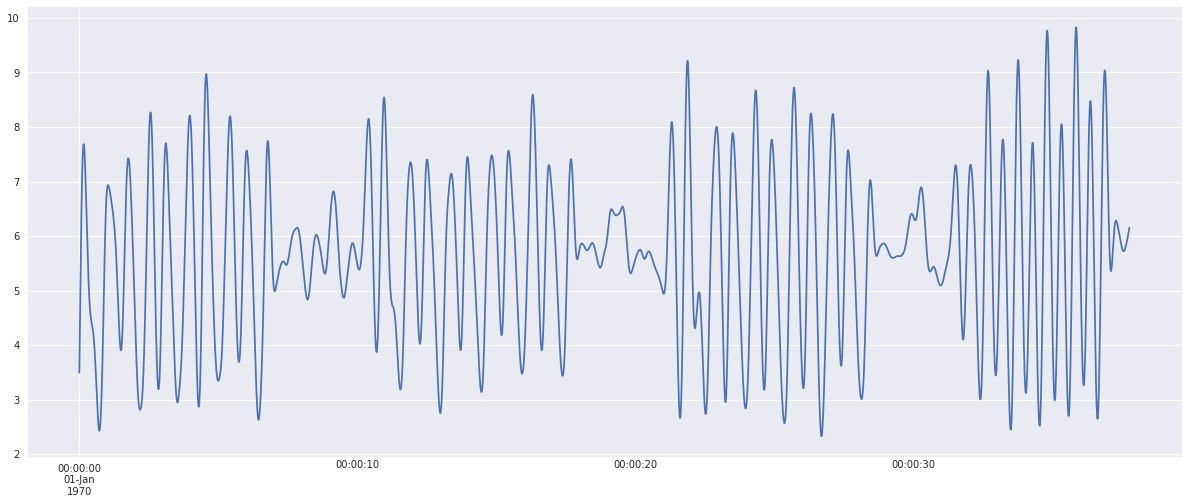

In [14]:
df.x.plot()

In [457]:
import scipy.signal as sig
from scipy.cluster.vq import kmeans, vq

def smoothing_window(data, window=[1, 1, 1]):
    
    for i in range(len(data) - sum(window)):
        
        start_window_from = i
        start_window_to = i+window[0]

        end_window_from = start_window_to + window[1]
        end_window_to = end_window_from + window[2]

        if np.all(data[start_window_from: start_window_to] == data[end_window_from: end_window_to]):
            data[start_window_from: end_window_to] = clusters[start_window_from]
            
    return data
    

def cluster_walk_turn(data, window=[1, 1, 1], plot=False):
    peaks, _ = sig.find_peaks(data)
    prominences = sig.peak_prominences(data, peaks)[0]
    
    # we use 2 clusters because we care about walking and turning only
    codebook, _ = kmeans(prominences, 2)
    clusters, _ = vq(prominences, codebook)
    
    # make sure walking is class 0 and turning class 1
#     _, counts = np.unique(c, return_counts=1)
#     if counts[0] > counts[1]:
#         clusters = np.array(clusters==0, dtype=np.int)
    
    # this is a conveniance function to fix errors in clustering
    # this will look into the clusters and if it finds 'tolerance'
    # number of samples in the middle of a different class
    # it will move them to the class that sorrounds the points
    if plot:
        plt.plot(prominences)
        plt.plot(clusters, 'ro', alpha=0.5)
    
    # NOTE: need to think more about this...
    if window:
        
#         clusters = smoothing_windo(clusters, window=window)
#         for i in range(len(clusters) - sum(window)):
#             start_window_from = i
#             start_window_to = i+window[0]
        
#             end_window_from = start_window_to + window[1]
#             end_window_to = end_window_from + window[2]
# #             print('[{}: {}] [{}: {}]'.format(start_window_from, start_window_to, end_window_from, end_window_to))
# #             print(clusters[start_window_from: start_window_to], clusters[end_window_from: end_window_to])
            
#             if np.all(clusters[start_window_from: start_window_to] == clusters[end_window_from: end_window_to]):
#                 clusters[start_window_from: end_window_to] = clusters[start_window_from]
# #                 print(clusters[start_window_from: end_window_to], clusters[start_window_from: start_window_to], clusters[end_window_from: end_window_to])
    
    
    if plot:
        plt.plot(clusters, 'go', alpha=0.5)
        
    return clusters, peaks, prominences

In [458]:
def plot_walk_turn(data, window=[1, 1, 1]):
    c, pk, p = cluster_walk_turn(data.values, window=window)
    
    contour_heights = data.values[pk] - p
    
    colors = [['red', 'green'][i] for i in c]
    plt.plot(data.values)
    plt.scatter(pk, data.values[pk], color=colors)
    plt.vlines(x=pk, ymin=contour_heights, ymax=data.values[pk], color=colors)

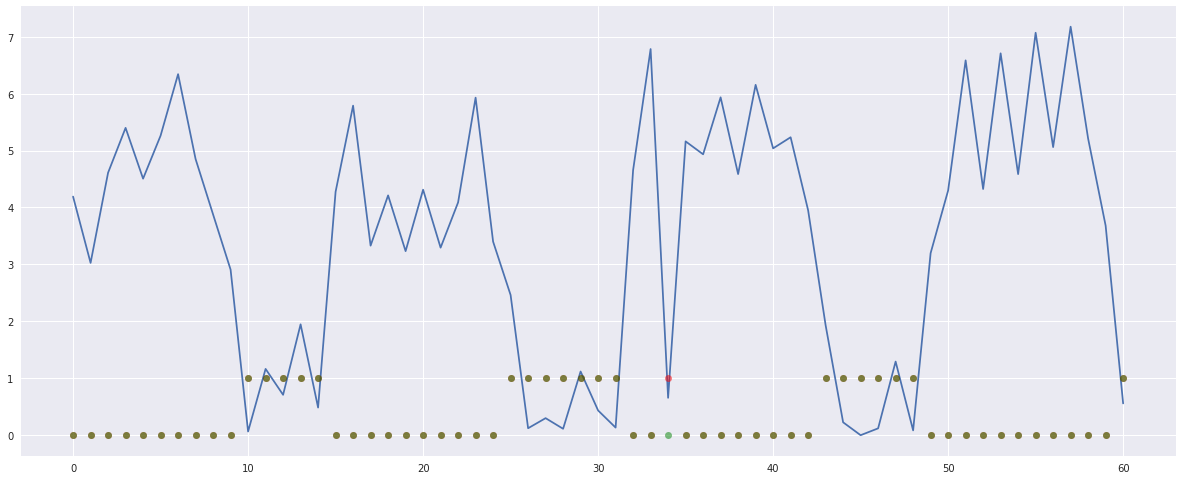

In [459]:
c, pk, p = cluster_walk_turn(df.x.values, window=[1, 1, 2], plot=True)

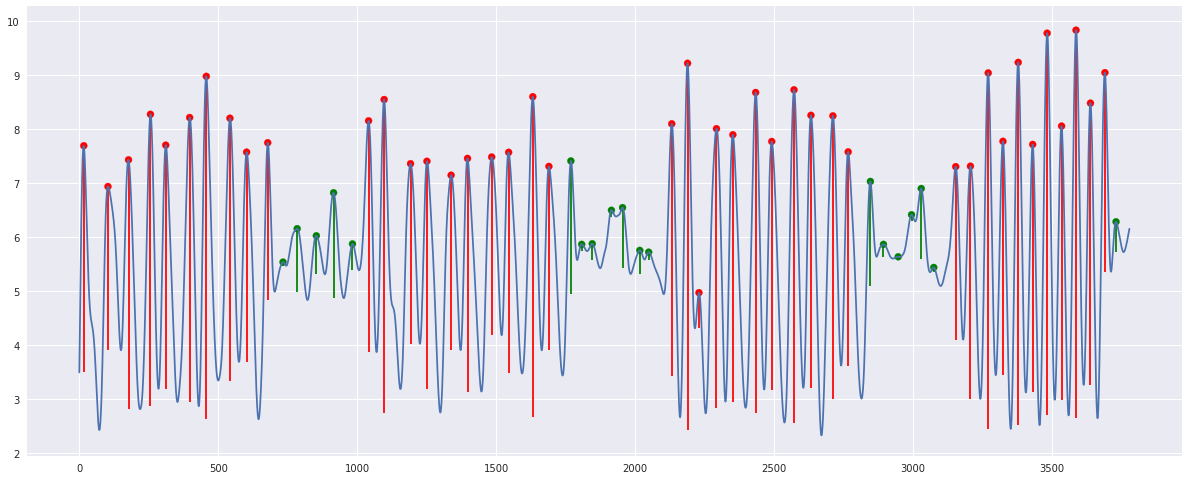

In [460]:
plot_walk_turn(df.x, window=[1, 1, 2])

In [338]:
np.unique(c, return_counts=1)

(array([0, 1], dtype=int32), array([42, 19]))

In [469]:
def separate_walks_turns(clusters, peaks):
    
    group_one = []
    group_two = []
    
    start = 0

    for i in range(1, len(clusters)):        
        if c[i-1] != c[i]:
            assert np.all(clusters[start: i] == clusters[start]), 'Some values are mixed up, please check!'
            if c[start] == 0:
                add = group_one
            else:
                add = group_two

            add.append(peaks[start: i])
            start = i
    
    count_one = [len(c) for c in group_one]
    count_two = [len(c) for c in group_two]
    
    walks, turns = group_two, group_one
    
    if sum(count_one) > sum(count_two):
        walks, turns = group_one, group_two
    
    return walks, turns

In [470]:
walks, turns = separate_walks_turns(c, pk)

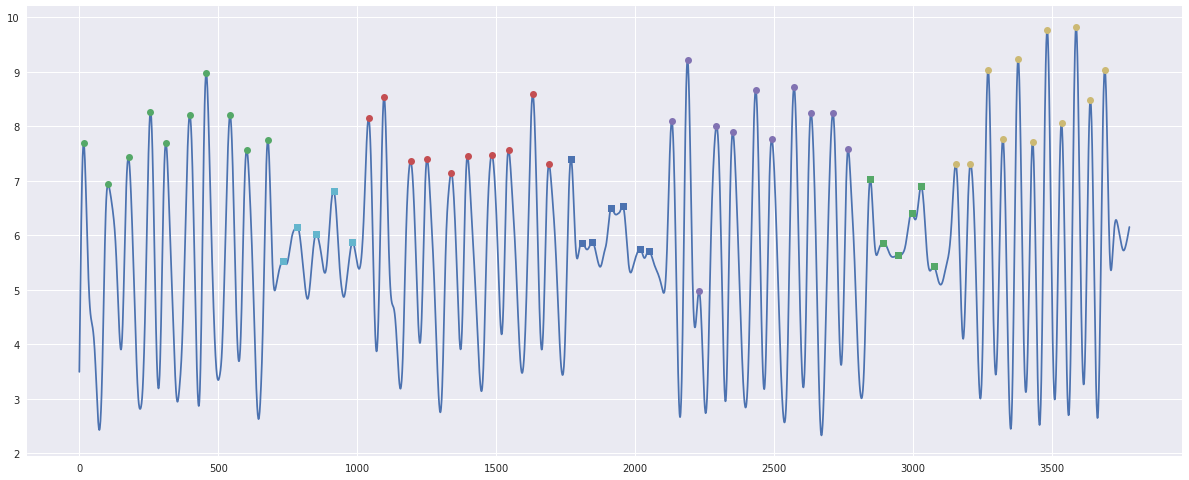

In [468]:
plt.plot(df.x.values)
for w in walks:
    plt.plot(w, df.x.values[w], 'o')

for t in turns:
    plt.plot(t, df.x.values[t], 's')

In [375]:
turns

[array([733, 784, 853, 915, 983]),
 array([1769, 1808, 1846, 1915, 1955, 2017, 2049]),
 array([2847, 2894, 2947, 2995, 3030, 3075])]

In [415]:
vals = sig.argrelextrema(df.x.values, np.less)[0]

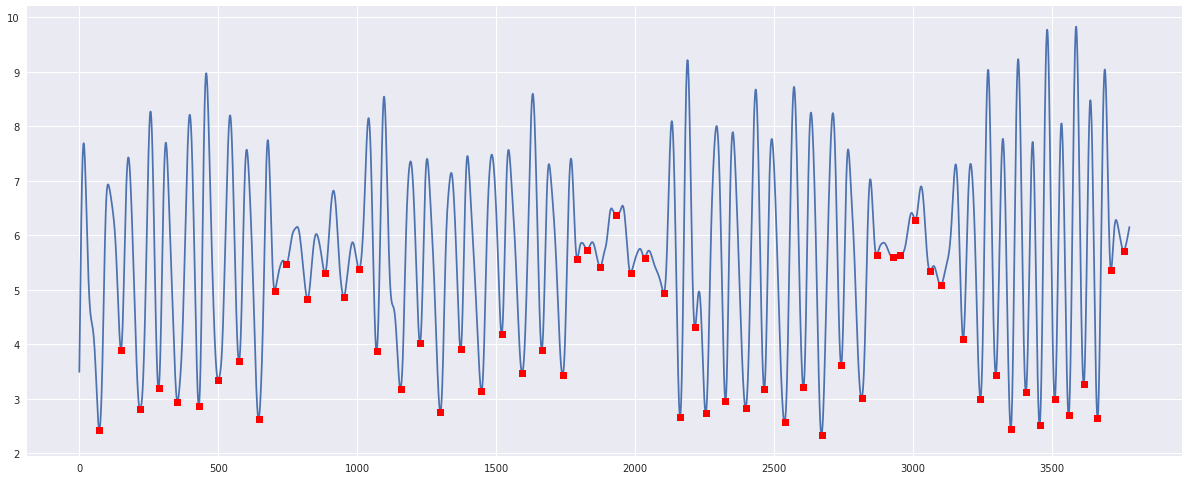

In [418]:
plt.plot(df.x.values)
plt.plot(vals, df.x.values[vals], 'rs')

In [427]:
start_vals = vals[vals < turns[0][0]][-1]
end_vals = vals[vals > turns[0][-1]][0]

In [444]:
vals < turns[0][0]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [443]:
vals > turns[0][-1]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [334]:
def get_peaks_valleys(data):
    top = sig.argrelextrema(data, np.greater)[0]
    bot = sig.argrelextrema(data, np.less)[0]
    
    return top, bot

def get_turns_with_thresh(data, thresh=[-1, 1]):
    top, bot = get_peaks_valleys(data)
    
    top = top[data[top] < np.max(thresh)]
    bot = bot[data[bot] > np.min(thresh)]
    
    return top, bot

def get_turns_from_distance(data, max_distance=1.5):
    top, bot = get_peaks_valleys(data)
    
    differences = data[top] - data[bot]
    
    turns_top = []
    turns_bot = []
    
    for i, d in enumerate(differences):
        if d < max_distance:
            turns_top.append(top[i])
            turns_bot.append(bot[i])
            
    return turns_top, turns_bot

In [335]:
tt, tb = get_turns_from_distance(df.x.values)

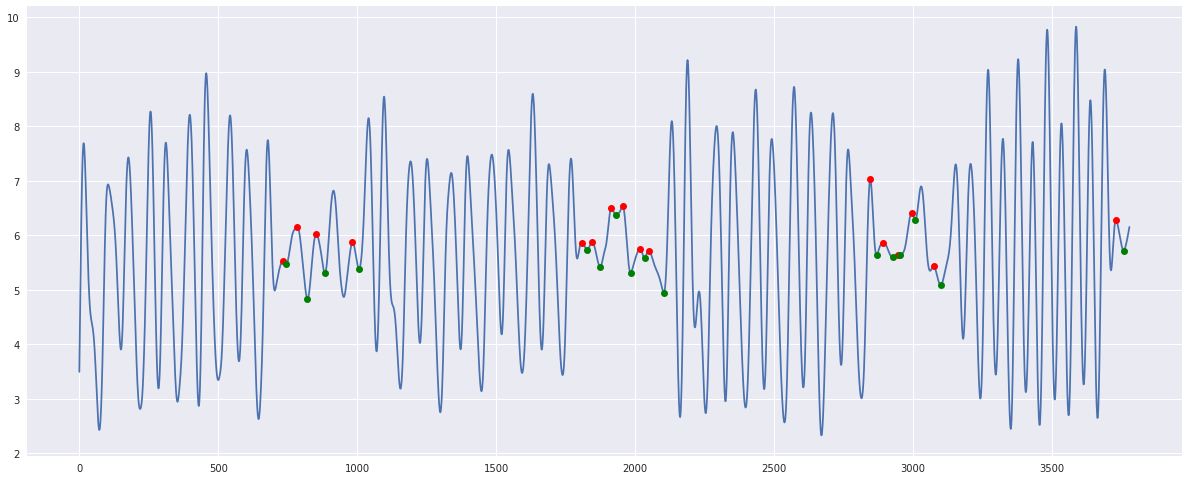

In [337]:
plt.plot(df.x.values)
plt.plot(tt, df.x.values[tt], 'ro')
plt.plot(tb, df.x.values[tb], 'go')

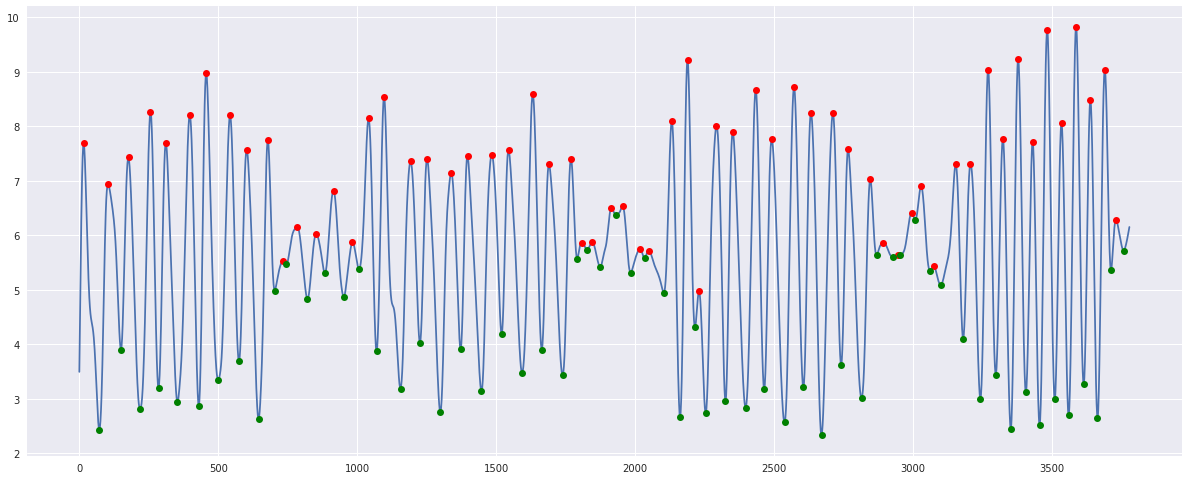

In [250]:
plt.plot(df.x.values)
plt.plot(top, df.x.values[top], 'ro')
plt.plot(bot, df.x.values[bot], 'go')

In [268]:
from scipy.spatial.distance import euclidean

In [ ]:
euclidean()

In [397]:
np.sqrt((top - bot) ** 2 + (df.x.values[top] - df.x.values[bot]) ** 2)

array([56.24619297, 47.09741617, 42.25228238, 29.44092055, 42.26778573,
       33.42899561, 43.36634541, 33.30604463, 43.28272765, 25.15146879,
       12.00019009, 37.02353874, 31.00817423, 37.05129005, 24.00495656,
       29.31355133, 59.24243198, 34.16271595, 48.2243084 , 34.15344808,
       50.18559474, 36.15048192, 48.17390308, 32.34186462, 49.15236294,
       23.07293717, 19.00041125, 28.00365851, 17.00039333, 29.02598259,
       17.00084476, 54.00559218, 30.48688849, 27.44103598, 24.10356612,
       32.3953452 , 46.27621259, 31.48282553, 46.29273273, 34.44351934,
       38.45804825, 30.35320429, 48.21642515, 22.04402755, 34.00101738,
        6.00000079, 13.00058272, 32.03736973, 25.00234722, 27.1888602 ,
       36.25621986, 27.57229746, 28.50064948, 27.68110751, 25.53290931,
       27.83785585, 25.56594376, 28.7576553 , 25.66963105, 22.30587554,
       27.00582731])

In [407]:
signal_walk = []

for i in range(1, len(top)):
#     print(top[i-1], bot[i-1])
#     print(bot[i-1], top[i])
    
    t_b = np.sqrt( (top[i-1] - bot[i-1]) ** 2 + (df.x.values[top[i-1]] - df.x.values[bot[i-1]]) ** 2)
    b_t = np.sqrt( (bot[i-1] - top[i]) ** 2 + (df.x.values[bot[i-1]] - df.x.values[top[i]]) ** 2)
    
    signal_walk += [t_b, b_t]

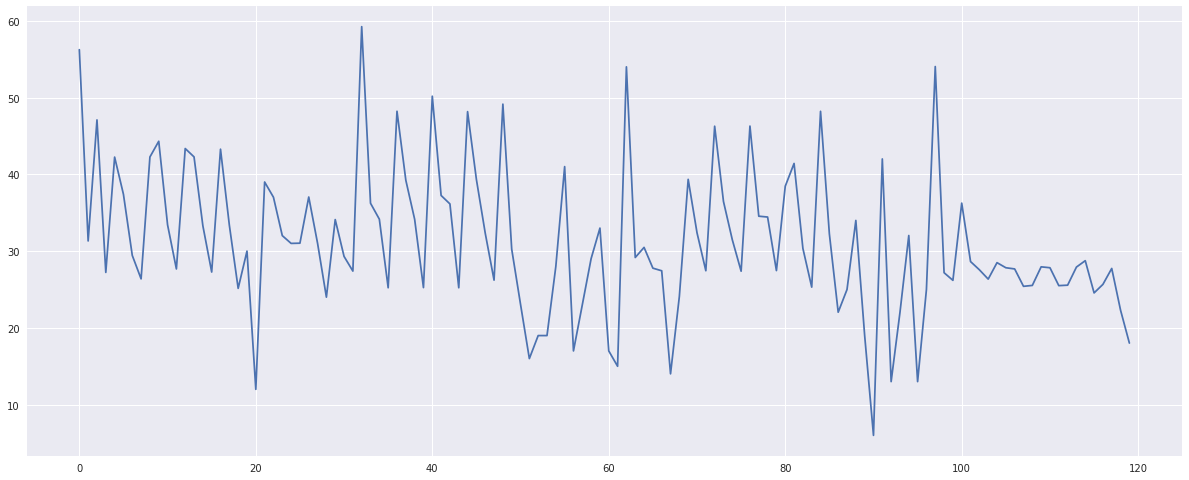

In [409]:
plt.plot(signal_walk)

In [283]:
tops = list(zip(top, df.x.values[top]))
bots = list(zip(bot, df.x.values[bot]))

for t, b in zip(tops, bots):

    print(t,b,euclidean(u=t, v=b))

(16, 7.687967282552365) (72, 2.4311408843578612) 56.24619297144256
(103, 6.933406929510645) (150, 3.9057659665792372) 47.09741616904711
(177, 7.427107749813201) (219, 2.816753531636933) 42.25228237642383
(256, 8.268962087377625) (285, 3.1927624409577198) 29.440920550321003
(311, 7.6988376293410035) (353, 2.948499676517723) 42.267785731760696
(397, 8.209355422943556) (430, 2.871027283834993) 33.42899560741839
(457, 8.971301356391145) (500, 3.3463645538480624) 43.36634540784598
(542, 8.19702893736857) (575, 3.692297086808082) 33.30604463225038
(602, 7.56998858637312) (645, 2.6309084005197496) 43.282727652982885
(678, 7.744184984759952) (703, 4.988031450800141) 25.15146879016729
(733, 5.536263040517274) (745, 5.468719448411669) 12.00019008752922
(784, 6.154577363870785) (821, 4.834569536640538) 37.023538737726696
(853, 6.023098532840447) (884, 5.31115123661567) 31.0081742279774
(915, 6.818303288388289) (952, 4.869433196796728) 37.051290053571684
(983, 5.87234026682148) (1007, 5.3845497123

In [282]:
tops

[(16, 7.687967282552365),
 (103, 6.933406929510645),
 (177, 7.427107749813201),
 (256, 8.268962087377625),
 (311, 7.6988376293410035),
 (397, 8.209355422943556),
 (457, 8.971301356391145),
 (542, 8.19702893736857),
 (602, 7.56998858637312),
 (678, 7.744184984759952),
 (733, 5.536263040517274),
 (784, 6.154577363870785),
 (853, 6.023098532840447),
 (915, 6.818303288388289),
 (983, 5.87234026682148),
 (1041, 8.148641634960345),
 (1097, 8.542309743635478),
 (1192, 7.355799783672976),
 (1251, 7.400581938743145),
 (1338, 7.142849390973414),
 (1397, 7.453828702844537),
 (1484, 7.479393841404737),
 (1545, 7.566402859588539),
 (1632, 8.594666573554813),
 (1690, 7.305505185577446),
 (1769, 7.406583116309147),
 (1808, 5.864616788909179),
 (1846, 5.875636298071421),
 (1915, 6.494687029438887),
 (1955, 6.543762817555841),
 (2017, 5.752897640384707),
 (2049, 5.720080773033299),
 (2132, 8.093352410715717),
 (2189, 9.212914522775424),
 (2230, 4.971279449839617),
 (2293, 8.002997004287275),
 (2352, 7.